# Explore here

In [1]:
# Importamos las librerias necesarias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import *
from pickle import dump

# Datos

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/raw/sales.csv')

In [3]:
# Visualizamos los datos
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [4]:
# Visualizamos la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [5]:
# Visualizamos la cantidad de valores nulos
df.isnull().sum()

date     0
sales    0
dtype: int64

In [6]:
# Convertimos la columna de fecha a datetime
df['date'] = pd.to_datetime(df['date'])

In [7]:
# Convertimos la columna de fecha en el indice
df = df.set_index('date')

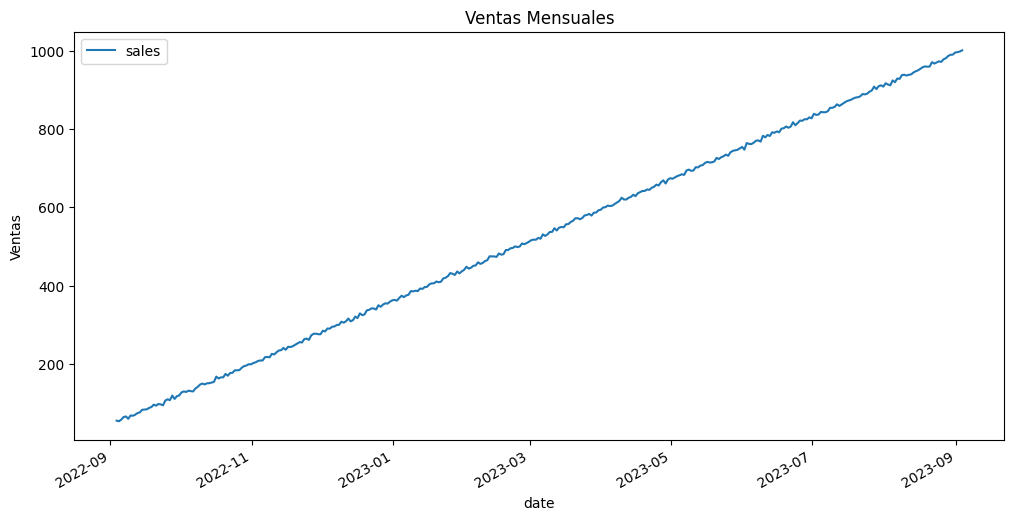

In [8]:
# Graficamos la serie de tiempo
df.plot(figsize=(12, 6))
plt.title("Ventas Mensuales")
plt.ylabel("Ventas")
plt.show()

# Análisis de la Serie

¿Cuál es el tensor de la serie temporal?

In [9]:
# Verificamos la frecuencia de los datos
print(df.index.freq)

None


In [10]:
# Como la frecuencia es None, la inferimos
print(pd.infer_freq(df.index))

D


El tensor es la unidad mínima de tiempo con datos.
Como freq='D', el tensor es 1 día.

In [11]:
# asignamos la frecuencia a los datos
df = df.asfreq('D')
print(df.index.freq)

<Day>


In [12]:
# Revisamos si hay valores nulos
df = df.asfreq("D").dropna()

¿Cuál es la tendencia?

<Axes: xlabel='date'>

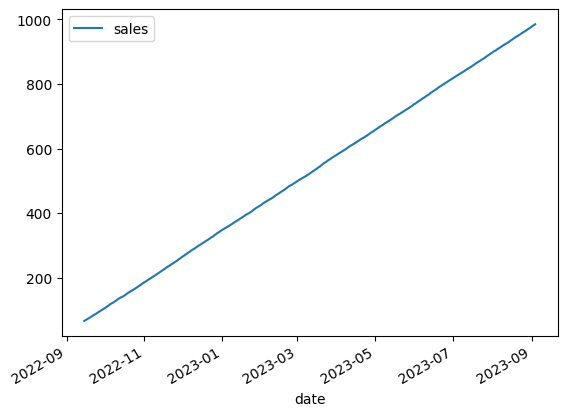

In [13]:
# Observamos si hay crecimiento/decaimiento con una gráfica.
# Usamos una media móvil para suavizar:
tendencia = df.rolling(window=12).mean()
tendencia.plot()

Podemos observar la tendencia visualmente en el gráfico. Como vemos un aumento general a lo largo del tiempo, hay una tendencia alcista.

¿Es estacionaria?

In [ ]:
# Verificamos si los datos son estacionarios
estacionaria = adfuller(df['sales'])
print('p-value: ', estacionaria[1])
if estacionaria[1] <= 0.05:
    print("Los datos no tienen raíz unitaria y son estacionarios.")
else:
    print("Los datos tienen una raíz unitaria y no son estacionarios.")

p-value:  0.986189981531106
Los datos tienen una raíz unitaria y no son estacionarios.


¿Existe variabilidad o presencia de ruido?

Como se puede observar visualmente en el gráfico. No hay fluctuaciones irregulares alrededor de la tendencia, no hay presencia de ruido.

# Datos de Entrenamiento y Prueba

In [15]:
# separamos los datos en entrenamiento y prueba
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Escalado de Datos

In [16]:
# Instanciamos el escalador
scaler = StandardScaler()

# Entrenamos y escalamos los datos de entrenamiento
train_sc = scaler.fit_transform(train[["sales"]])  
test_sc = scaler.transform(test[["sales"]]) 

# ARIMA

In [17]:
# AutoARIMA con búsqueda inteligente
model = auto_arima(
    train_sc,
    seasonal=False,
    d=1,
    stepwise=True,
    trace=True,
    error_action="ignore"
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1657.021, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1461.433, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1558.298, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1661.686, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1373.100, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1660.895, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1661.359, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1657.830, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1373.937, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.856 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 833.843
Date:               sá., 08 mar. 2025   

In [18]:
# Hacer predicciones
n_steps = len(test_sc)
forecast, conf_int = model.predict(n_periods=n_steps, return_conf_int=True)

# Convertir las predicciones a un DataFrame para facilitar el manejo
predictions_sc = pd.Series(forecast, index=test.index)

# Mostrar las predicciones
print(predictions_sc)

date
2023-06-22 17:10:08.079328    1.739992
2023-06-23 17:10:08.079328    1.751844
2023-06-24 17:10:08.079328    1.763695
2023-06-25 17:10:08.079328    1.775546
2023-06-26 17:10:08.079328    1.787398
                                ...   
2023-08-30 17:10:08.079328    2.557732
2023-08-31 17:10:08.079328    2.569584
2023-09-01 17:10:08.079328    2.581435
2023-09-02 17:10:08.079328    2.593286
2023-09-03 17:10:08.079328    2.605138
Freq: D, Length: 74, dtype: float64


In [19]:
# Desescalar las predicciones
predictions_sc = model.predict(n_periods=len(test_sc))
predictions = scaler.inverse_transform(predictions_sc.reshape(-1, 1))

# Convertir las predicciones a un DataFrame para facilitar el manejo
predictions = pd.Series(predictions.flatten(), index=test.index)

print(predictions)

date
2023-06-22 17:10:08.079328    810.088511
2023-06-23 17:10:08.079328    812.685829
2023-06-24 17:10:08.079328    815.283148
2023-06-25 17:10:08.079328    817.880466
2023-06-26 17:10:08.079328    820.477784
                                 ...    
2023-08-30 17:10:08.079328    989.303482
2023-08-31 17:10:08.079328    991.900801
2023-09-01 17:10:08.079328    994.498119
2023-09-02 17:10:08.079328    997.095438
2023-09-03 17:10:08.079328    999.692756
Freq: D, Length: 74, dtype: float64


In [20]:
# calcular el error cuadrático medio
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 7.79
MAE: 2.22


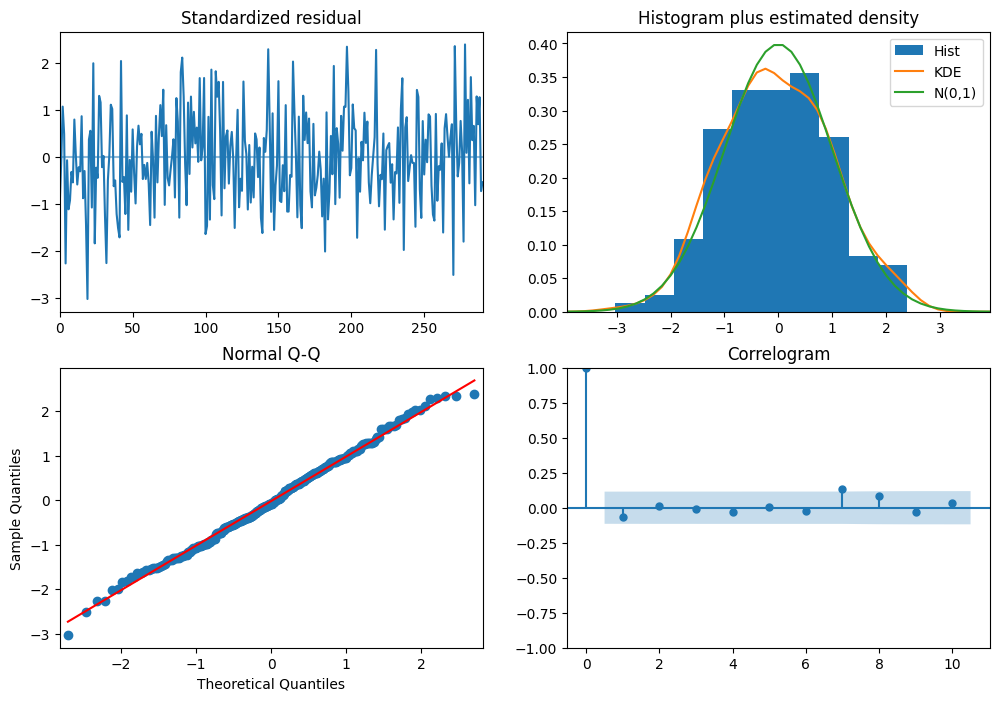

In [21]:
# Gráficos de diagnóstico de residuos
model.plot_diagnostics(figsize=(12, 8))
plt.show()

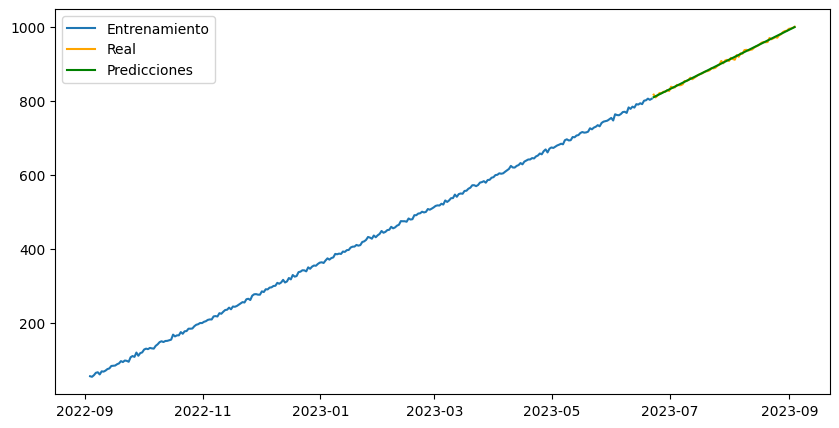

In [22]:
# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Real', color='orange')
plt.plot(predictions, label='Predicciones', color='green')
plt.legend()
plt.show()

# Validación Cruzada

Fold 1 - MAE: 5.37
Fold 2 - MAE: 2.46
Fold 3 - MAE: 2.38
Fold 4 - MAE: 2.60
Fold 5 - MAE: 2.30

📊 Evaluación con Validación Cruzada (TimeSeriesSplit)
🔹 MAE Promedio: 3.02
🔹 Desviación estándar MAE: 1.18
🏆 Mejor MAE: 2.30

📌 🔥 Mejor Modelo AUTOARIMA Seleccionado 🔥
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -766.310
Date:               sá., 08 mar. 2025   AIC                           1540.619
Time:                        00:10:12   BIC                           1555.487
Sample:                    09-03-2022   HQIC                          1546.567
                         - 07-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

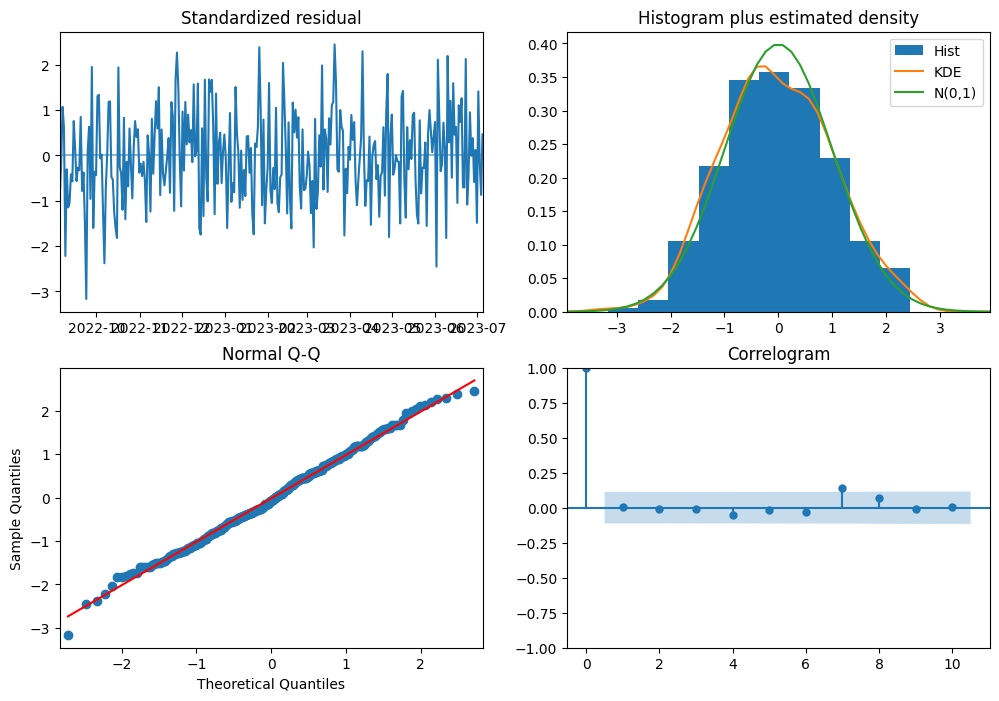

In [23]:
# Configurar validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
models = []  # Lista para almacenar los modelos
best_model = None
best_mae = float("inf")

# Iterar sobre los diferentes splits
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Entrenar el modelo AUTOARIMA en la parte de entrenamiento
    model = pm.auto_arima(train,
                       seasonal=False,
                       stepwise=True,
                       suppress_warnings=True)   

    # Hacer predicciones sobre la parte de test
    preds = model.predict(n_periods=len(test))

    # Evaluar el error MAE
    mae = mean_absolute_error(test, preds)
    mae_scores.append(mae)
    models.append(model)

    print(f"Fold {len(mae_scores)} - MAE: {mae:.2f}")

    # Guardar el mejor modelo basado en MAE
    if mae < best_mae:
        best_mae = mae
        best_model = model

# 📌 Promedio del error en la validación cruzada
print("\n📊 Evaluación con Validación Cruzada (TimeSeriesSplit)")
print(f"🔹 MAE Promedio: {np.mean(mae_scores):.2f}")
print(f"🔹 Desviación estándar MAE: {np.std(mae_scores):.2f}")
print(f"🏆 Mejor MAE: {best_mae:.2f}")

# 📌 Resumen del mejor modelo
print("\n📌 🔥 Mejor Modelo AUTOARIMA Seleccionado 🔥")
print(best_model.summary())

# 📊 Diagnóstico del mejor modelo
best_model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Save los archivos

In [24]:
# Guardamos el modelo

dump(model, open("../models/ARIMA.sav", "wb"))

# Conclusiones

El SARIMAX(0,1,1) no solo es técnicamente superior en métricas clave, sino que también ofrece ventajas operativas para entornos empresariales: simplicidad, transparencia y bajo costo computacional. Su implementación garantiza predicciones confiables para la planificación estratégica del almacén.